In [15]:
!pip install pandas numpy matplotlib seaborn scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

sns.set(style="whitegrid")




In [17]:
# 2 ans de données quotidiennes
dates = pd.date_range(start="2023-01-01", end="2024-12-31", freq="D")

services = ["urgences_adultes", "urgences_pediatriques", "rea", "cardio"]

rows = []

for date in dates:
    jour_semaine = date.weekday()
    mois = date.month

    # saison
    if mois in [12, 1, 2]:
        saison = "hiver"
    elif mois in [3, 4, 5]:
        saison = "printemps"
    elif mois in [6, 7, 8]:
        saison = "ete"
    else:
        saison = "automne"

    # type de jour
    type_jour = "weekend" if jour_semaine >= 5 else "semaine"

    # événement (épidémies plus probables en hiver, canicule en été)
    evenement = 0
    if saison == "hiver" and np.random.rand() < 0.2:
        evenement = 1  # grippe
    if saison == "ete" and np.random.rand() < 0.05:
        evenement = 2  # canicule

    for service in services:
        # base admissions par service
        if service == "urgences_adultes":
            base = 120
        elif service == "urgences_pediatriques":
            base = 60
        elif service == "rea":
            base = 30
        else:  # cardio
            base = 40

        factor = 1.0

        # effets saisonniers
        if saison == "hiver" and service in ["urgences_pediatriques", "rea"]:
            factor += 0.3

        # weekend
        if type_jour == "weekend":
            factor -= 0.1

        # événements
        if evenement == 1 and service in ["urgences_pediatriques", "rea"]:
            factor += 0.5
        if evenement == 2 and service in ["urgences_adultes", "rea"]:
            factor += 0.4

        admissions = np.random.poisson(max(base * factor, 1))

        # lits
        lits_total = 80 if service == "urgences_adultes" else 50
        lits_occupees = min(lits_total, int(admissions * 0.6 + np.random.randint(-5, 6)))
        lits_occupees = max(lits_occupees, 0)
        lits_disponibles = lits_total - lits_occupees

        # personnel
        personnel_base = 20 if service == "urgences_adultes" else 10
        personnel_present = personnel_base + np.random.randint(-2, 3)
        personnel_present = max(personnel_present, 1)

        rows.append({
            "date": date,
            "jour_semaine": jour_semaine,
            "mois": mois,
            "saison": saison,
            "type_jour": type_jour,
            "evenement": evenement,
            "service": service,
            "admissions": admissions,
            "lits_total": lits_total,
            "lits_occupees": lits_occupees,
            "lits_disponibles": lits_disponibles,
            "personnel_present": personnel_present
        })

df = pd.DataFrame(rows)
df.head()



,date,jour_semaine,mois,saison,type_jour,evenement,service,admissions,lits_total,lits_occupees,lits_disponibles,personnel_present
0,2023-01-01,6,1,hiver,weekend,0,urgences_adultes,107,80,69,11,22
1,2023-01-01,6,1,hiver,weekend,0,urgences_pediatriques,61,50,39,11,12
2,2023-01-01,6,1,hiver,weekend,0,rea,44,50,28,22,9
3,2023-01-01,6,1,hiver,weekend,0,cardio,51,50,25,25,9
4,2023-01-02,0,1,hiver,semaine,0,urgences_adultes,143,80,80,0,18


In [18]:
df.describe(include="all")



,date,jour_semaine,mois,saison,type_jour,evenement,service,admissions,lits_total,lits_occupees,lits_disponibles,personnel_present
count,2924,2924.000000,2924.000000,2924,2924,2924.000000,2924,2924.00000,2924.000000,2924.000000,2924.000000,2924.000000
unique,NaN,NaN,NaN,4,2,NaN,4,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,printemps,semaine,NaN,urgences_adultes,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,736,2088,NaN,731,NaN,NaN,NaN,NaN,NaN
mean,2024-01-01 00:00:00,2.997264,6.519836,NaN,NaN,0.058824,NaN,63.23290,57.500000,37.286252,20.213748,12.498632
min,2023-01-01 00:00:00,0.000000,1.000000,NaN,NaN,0.000000,NaN,10.00000,50.000000,5.000000,0.000000,8.000000
25%,2023-07-02 00:00:00,1.000000,4.000000,NaN,NaN,0.000000,NaN,35.00000,50.000000,21.000000,11.000000,9.000000
50%,2024-01-01 00:00:00,3.000000,7.000000,NaN,NaN,0.000000,NaN,49.00000,50.000000,29.000000,21.000000,11.000000
75%,2024-07-02 00:00:00,5.000000,10.000000,NaN,NaN,0.000000,NaN,94.00000,57.500000,50.000000,29.000000,13.500000
max,2024-12-31 00:00:00,6.000000,12.000000,NaN,NaN,2.000000,NaN,183.00000,80.000000,80.000000,45.000000,22.000000


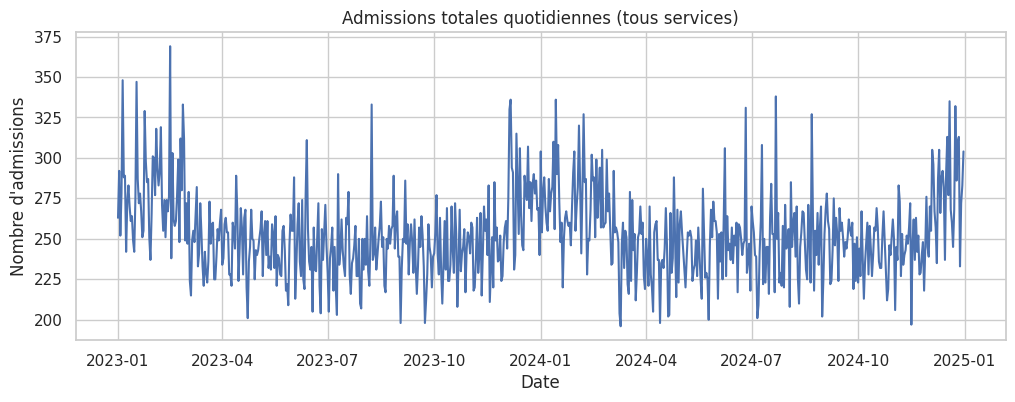

In [19]:
df_jour = df.groupby("date")["admissions"].sum().reset_index()

plt.figure(figsize=(12,4))
plt.plot(df_jour["date"], df_jour["admissions"])
plt.title("Admissions totales quotidiennes (tous services)")
plt.xlabel("Date")
plt.ylabel("Nombre d'admissions")
plt.show()


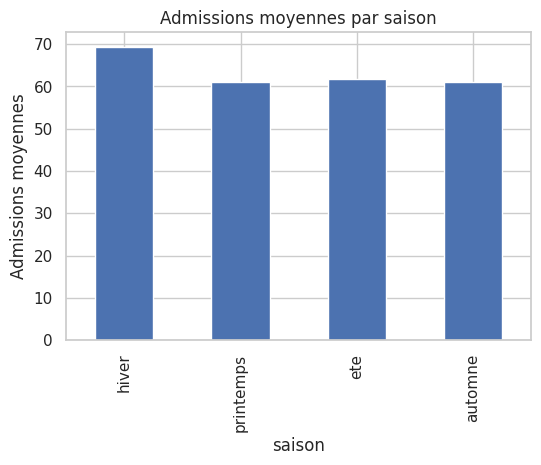

In [20]:
df_saison = df.groupby("saison")["admissions"].mean().reindex(["hiver","printemps","ete","automne"])

plt.figure(figsize=(6,4))
df_saison.plot(kind="bar")
plt.title("Admissions moyennes par saison")
plt.ylabel("Admissions moyennes")
plt.show()


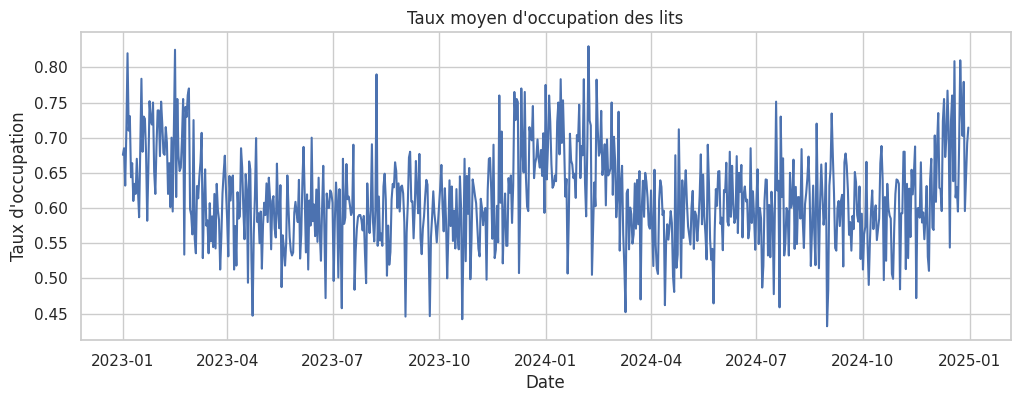

In [21]:
df["taux_occupation"] = df["lits_occupees"] / df["lits_total"]

df_occ = df.groupby("date")["taux_occupation"].mean().reset_index()

plt.figure(figsize=(12,4))
plt.plot(df_occ["date"], df_occ["taux_occupation"])
plt.title("Taux moyen d'occupation des lits")
plt.xlabel("Date")
plt.ylabel("Taux d'occupation")
plt.show()


In [23]:
df_model = df.copy()

# Encodage des variables catégorielles
df_model = pd.get_dummies(df_model,
                          columns=["saison", "type_jour", "service"],
                          drop_first=True)

# On enlève 'date' qui n'est pas directement utilisable en numérique ici
X = df_model.drop(columns=["admissions", "date"])
y = df_model["admissions"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [24]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

mae, rmse


(3.9031046425843896, 4.943549797404597)

In [25]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": lin_reg.coef_
}).sort_values(by="coef", ascending=False)

coef_df.head(15)


,feature,coef
14,service_urgences_pediatriques,7.774954
2,evenement,5.649499
9,saison_hiver,2.641185
4,lits_occupees,1.403904
3,lits_total,0.678082
10,saison_printemps,0.300068
13,service_urgences_adultes,0.022603
1,mois,0.017742
0,jour_semaine,-0.037505
6,personnel_present,-0.054579


In [28]:
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5

mae_rf, rmse_rf


(3.898421177587844, 4.9077062492823655)

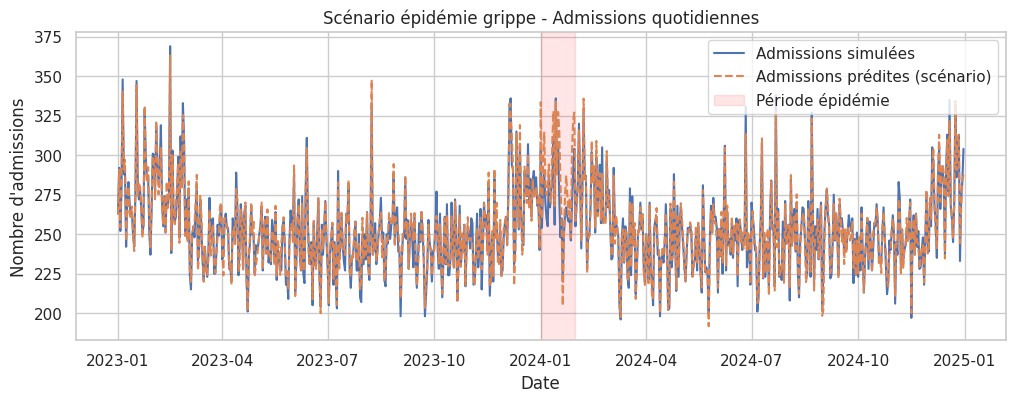

In [29]:
df_scenario = df.copy()

# Exemple : épidémie grippe sur janvier 2024
mask_epi = (df_scenario["date"] >= "2024-01-01") & (df_scenario["date"] <= "2024-01-31")
df_scenario.loc[mask_epi, "evenement"] = 1  # grippe

# Recalcule éventuellement des effets sur admissions si tu veux rendre ça encore plus réaliste,
# sinon on laisse le modèle prédire l'impact.

# Préparation pour le modèle
df_scenario_model = df_scenario.copy()
df_scenario_model = pd.get_dummies(df_scenario_model,
                                   columns=["saison", "type_jour", "service"],
                                   drop_first=True)

# On s'assure d'avoir les mêmes colonnes que X_train
df_scenario_model = df_scenario_model[X_train.columns]

df_scenario["admissions_predites"] = rf.predict(df_scenario_model)

# Agrégation par jour
df_compare = df_scenario.groupby("date")[["admissions", "admissions_predites"]].sum().reset_index()

plt.figure(figsize=(12,4))
plt.plot(df_compare["date"], df_compare["admissions"], label="Admissions simulées")
plt.plot(df_compare["date"], df_compare["admissions_predites"], label="Admissions prédites (scénario)", linestyle="--")
plt.axvspan(pd.to_datetime("2024-01-01"), pd.to_datetime("2024-01-31"), color="red", alpha=0.1, label="Période épidémie")
plt.legend()
plt.title("Scénario épidémie grippe - Admissions quotidiennes")
plt.xlabel("Date")
plt.ylabel("Nombre d'admissions")
plt.show()
